# Screens and Stimuli

## Overview
To make an application you need to present stimuli to your participant with sufficient meta-information to correctly analysis that data later.  In this tutorial we will show how to do this using the MindAffect software framework.

## System architecture

The mindaffect BCI system is made up of 4 key components:
1. Acquisition : This component talks to the measurment hardware to get the raw EEG data.
2. Hub : This component acts as a central server to connect all the other components together.  It is also responsible for saving the data-files and log-file to disk.
3. Presentation : This component is responsible for presenting stimuli to the user, and providing the main interaction user interface.
4. Decoder : This component is responsible for on-line analysis of the raw EEG data and stimulus information and generating predictions for the rest of the system. 

An illustration of the system components and how the interact with each other can be found here 

<img src='../../docs/SystemArchitecture.png' width=800>

In this notebook we will focus on how to make a presentation system using the 'Screens' classes.

## Key Concepts: Screens, Stimulus-state, stimulus-sequences and 'noisetags'
Before we start looking at code we need to understand the key concepts of 'Screens' and 'Stimulus Seqeuences'.

### Screen
In our framework a screen is the name for a class which will present information to the user.  The types of screens used in an application can be roughly divided into 2 types:
1. User-Interface screens.  These screens are used to provide the user-interface for an application to the user.   Think of things like a main-menu screen, or an electrode quality screen.  These screens normally don't interact with the BCI, except to present information or switch operating modes.
2. Stimulus Screens.   These screens are used to present stimuli to the participant for which we later will want to analyse the associated brain responses.  Think of the 'flicker screen' used for the c-VEP BCI or a flashing row/col screen for a P300 type speller.  These screens normally must be highly timing precise w.r.t. the stimulus presentation time and properties.  As we later want to cross-analyse the presented stimuli and the measured EEG, these screens must interact closely with the BCI to provide the appropriate information to the rest of the system for that later analysis.

#### Dumb-screens and Stimulus States
When presenting stimuli to the user for BCI purposes, it is important that the stimuli meet particular properties, e.g. on-duration, auto/cross correlation properties, etc.  In order to simplify the development of screens we have adopted a strict policy of separation of concerns.  With regard to screens this can be summarized as:  "stimulus-screens are dumb, and just present the stimuli as given in the current stimulus-state".   Where the stimulus-state describes the current stimulus state of the system.

### Stimulus State
The stimulus-state, describes the currently presented stimuli to the user, in the form of a number of stimulus-objects with associated stimulus-states.   For example, if we have 4 boxes on the screen, each box would be a stimulus object.  If each box can have, say, one of 3 colors (red,green, and blue) then each box can be in one of 3 stimulus states, (1=red, 2=green, 3=blue).   Thus, the complete stimulus state can be described by 4 numbers, e.g. [1,1,2,3], which is interperted by the screen as: object 1 in state 1, object 2 in state 1, object 3 in state 2, object 4 in state 3.   As a human-readable shortand we write this as 'o1.e1,o2.e1,o3.e2,o4.e3'.  

A screen will then define a mapping from stimulus-states to actual display properties, and when given the stimulus state set the various presentation objects to the appropriate states.  

### Noisetag object

By design screens are dumb, and do *not* have any concept of state, or how to talk to a BCI -- this makes it relatively easy to design new or special purpose screens as needed.  

Thus, the responsibility for sequencing of the stimuli and the communication with the BCI (i.e. the hub and the decoder).  Speficially, (for historic reasons), these two roles are managed by the [Noisetag object](`noisetag.py`).  Specifically it:
1. Manages the playback of the stimulus sequences to tell the Screen what to show at each point in time,
2. Communicates the information about the current stimulus state to the decoder, via. the Hub.

### Stimulus Sequences

The noisetag object simply plays back a given sequence of stimulus states.  The sequence of stimulus states is called a stimulus sequence, which is just a seqeuence of stimulus states over time.  As ensuring a stimulus sequence has optimal properties can be a computationally expensive task, such stimulus sequences are pre-compiled and loaded from file.   For more information on making stimulus sequences see [Make Stimulus Sequences.ipynb](Make Stimulus Sequences.ipynb).

Note: By default stimulus sequences are saved in the directory `mindaffectBCI\stimulus_seqeuence`

Here are 2 example binary stimulus sequences, as images, with time running vertically downwards and 'outputs' horizontally.  

<img src='../stimulus_sequence/mgold_61_6521_psk_60hz.png' height=600> _________
<img src='../stimulus_sequence/rc5x5.png' height=600>

##Question: One stimulus sequence is a random noise code, one is a p300 style 'row-column' code.   Can you identify which is which?



### Basic stimulus presentation -- Screen class

The most basic object to present stimuli to the user is a Screen class.  Functionally, for Stimulus presentation screens this class runs the following pseudo-code:
```
1. while screen is not finished:
3.     draw the presentation objects
```

Functionally, this is *not* implemented as a loop, but the application framework iterative calls the Screen's `draw` method very video frame.   Thus the key methods of the Screen are:
* _draw_ : This method draws the presentation objects.
* _is_done_ : This method returns true if the screen is finished displaying.
* _reset_ : This method resets the state of the screen, so it can be re-used.

### pyglet basics -- _batch_ and _group_ 

We use [pyglet](pyglet.org) for stimulus display.  This is a relatively low level cross-platform game design framework, which uses [openGL](www.opengl.org) for the control of the graphics hardward.  OpenGL is a *massive* topic, which we will not go into here.  However, an important concept for Screen's is that for optimizing drawing efficiency you should combine drawing operations into a single group, called a *batch*.  Fortunately, pyglet provides tools to easily add screen objects to a batch, and then they can be drawn a single fast operation.  See(https://pyglet.readthedocs.io/en/latest/programming_guide/graphics.html#batched-rendering) for more information on batches and groups. 

In [2]:
%load_ext autoreload
%autoreload 2

#### Minimal screen
Now lets define a minimal screen, which just shows the text 'hello-world' on the screen, for 200 frames.

In [3]:
import pyglet
from mindaffectBCI.presentation.screens.basic_screens import Screen

class MinimalScreen(Screen):
    '''Screen which shows a blank screen for duration or until key-pressed'''
    def __init__(self, window):
        super().__init__(window)
        # make a batch for rendering
        self.batch = pyglet.graphics.Batch()

        # make the text object, in the middle of the screen, and add to the batch
        self.text =pyglet.text.Label("Hello World", font_size=12, 
                                    x=self.window.width//2, y=self.window.height//2,
                                    color=(255, 255, 255, 255),
                                    anchor_x='center', anchor_y='center',
                                    batch=self.batch)
        self.reset()

    def reset(self):
        self.nframe = 0

    def is_done(self):
        ''' we are finished after 200 frames ~= 4s '''
        return self.nframe > 60*4

    def draw(self, t):
        ''' draw the batch '''
        self.nframe = self.nframe + 1
        self.batch.draw()

### ScreenRunner

So we have made the screen, how to we get to see it.  To do that we need something to setup the pyglet window, and call the screens draw method as needed.   This functionality is provided by the `ScreenRunner`.  To use this we first have to initialize the window with `initPyglet`, and then run the screen with `run_screen`.

In [4]:
from mindaffectBCI.presentation.ScreenRunner import initPyglet, run_screen, run


In [5]:
window = initPyglet(width=640,height=480)

Now that we have got the window, let's make the screen and connect it to it

In [6]:
# make the screen and connect to the windown
screen = MinimalScreen(window)

And now lets run the screen we have made.

Note: 
1. We reset the screen before running so we can run this cell multiple times
2. We set the draw-rate, as there is a bug when using the 'frame timing' code when running in a notebook...

In [7]:
screen.reset()
run_screen(window,screen,drawrate=1/30)

app exit
app exit
app exit
app exit
app exit
app exit


#### Notebook issues:
Running pyglet screens directly in the notebook causes some difficulties, which means stimulus presentation is not reliable.  To avoid these issues it is better to make the screen and window directly to run the screen.  For a screen defined in the file `ScreenNameScreen.py` with the class name `ScreenNameScreen`, this can be done directly using the `run` method of `ScreenRunner`.   For example, using the `MinimalScreen` implementation from the `MinimalScreen.py` file as:

In [1]:
from mindaffectBCI.presentation.ScreenRunner import run
run('MinimalScreen',width=640,height=480)

C:\Users\Developer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


app exit


## Minimal Stimulus Presentation Screen

To present stimulus, as mentioned above we use a `noisetag` object to load and run the stimulus sequence, and communicate the appropriate information to the BCI.

Thus, to make a minimal stimulus presentation object we need to :
1. Take a noisetag object as input
2. During every draw call:
3.       Ask the noisetag object for the current stimulus state, (using `getNextStimulusState`)
4.       and log the previous stimulus state, with the timestamp of the window flip (using `sendStimulusState` and `window.lastfliptime`)
5.       Update our display objects state to reflect the current stimulus state.

To make a minimal stimulus display object we will modify the MinimalScreen to include these facilities.


In [1]:
import pyglet
from mindaffectBCI.presentation.screens.basic_screens import Screen
class MinimalStimulusScreen(Screen):
    '''Screen which shows a blank screen for duration or until key-pressed'''
    def __init__(self, window, noisetag=None):
        super().__init__(window)
        self.noisetag = noisetag
        # make a batch for rendering
        self.batch = pyglet.graphics.Batch()

        # make the text object, in the middle of the screen, and add to the batch
        self.text =pyglet.text.Label("Hello World", font_size=12, 
                                    x=self.window.width//2, y=self.window.height//2,
                                    color=(255, 255, 255, 255),
                                    anchor_x='center', anchor_y='center',
                                    batch=self.batch)
        self.reset()

    def reset(self):
        self.nframe = 0

    def is_done(self):
        ''' we are finished when the stimulus sequence is finished '''
        return not self.noisetag.isRunning()

    def draw(self, t):
        ''' draw the batch '''
        self.nframe = self.nframe + 1

        # get the stimulus state from the noisetag object
        if self.noisetag:
            # log the previous stimulus state info @ the accurate window flip time
            self.noisetag.sendStimulusState(timestamp=self.window.lastfliptime)
            # get the next stimulus state to display, if there is one!
            try:
                stimulusState, target_idx, objIDs, sendEvent = self.noisetag.getNextStimulusState()
            except StopIteration:
                # this is raised if the stimulus sequence is already complete...
                return
                
            if stimulusState is None: 
                return

            # update the display to reflect the current stimulus state
            col = (255,255,255,255)
            if stimulusState[0]==0 : # state 0 -> grey
                col = (5,5,5,255)
            elif stimulusState[0]==1: # state 1 -> red
                col = (255,0,0,255)
            elif stimulusState[0]==2: # state 2 -> green
                col = (0,255,0,255)
            # update the label color
            self.text.color = col

        self.batch.draw()

To use this screen we need to :

1. create a `noisetag` object and set it's stimulus sequence
2. (Optional): connect the `noisetag` object to the Hub
2. create a window
3. create the screen with the window and noisetag object
4. tell the noisetag object to run the flicker sequence
5. run the screen

In [ ]:
# create the noisetag object and load a stimulus sequence to play
from mindaffectBCI.noisetag import Noisetag
nt = Noisetag(stimSeq='level2_gold.txt')
nt.startFlicker()

In [ ]:
from mindaffectBCI.presentation.ScreenRunner import initPyglet, run_screen, run
# make the window and run it
window = initPyglet(width=640, height=480)
screen = MinimalStimulusScreen(window,noisetag=nt)
run_screen(window, screen)

## Custom Stimulus seqeuences

If you ran the above stimulus sequence you will have noticed that the label changed very rapidly - in fact at 30Hz.   Depending on the stimulus design you want this may or may not be what you want.  Further, when used with multiple stimulus 'objects' the stimulus sequence `level3_gold.txt` will have all objects changing at the same time.   To make it easier to make a stimulus sequence with your desired properties the file [`stimseq.py`](../stimseq.py) contains different functions for manipulating stimulus sequences.  For example to slow a stimulus sequence down you can use `upsample_with_jitter` or to join two stimulus sequences together you can use `concatenate_objects`.   An overview of the most useful stimseq manipulation functions is given here:
* `upsample_with_jitter` - this function will *slow down* the input sequence, either by inserting all-zero stimulus states (if `latch` is False), or by repeating the stimulus state a number of times (when `latch` is true).   Further, the number of inserted states can be randomized to introduce some timing jitter with the `jitter` parameter.
* `concatenate_objects` - given 2 stimulus sequences make a combined sequence with the objects of sequence one before the objects of sequence 2.
* `interleave_objects` - Make a new *slowed-down* stimulus sequence where only `nactive` objects are active at any time point, by adding extra stimulus states where all other objects are in state zero.
* `rewrite_levels` - Map the levels in the input stimulus sequence to new levels according to the mapping given in the `new_levels` dictionary.

#### Modifying stimulus sequence example, slowing down with jitter
As an example of making a stimulus sequence with desired properties, here we make a new sequence which is simply slowed down with a bit of jitter.

<AxesSubplot:>

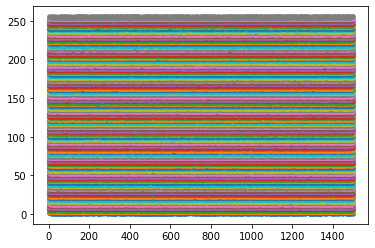

In [11]:
from mindaffectBCI.stimseq import StimSeq, upsample_with_jitter
# load the starting sequence
stimseq = StimSeq.fromFile('level3_gold.txt')
# and plot to visualize
stimseq.plot()

<AxesSubplot:>

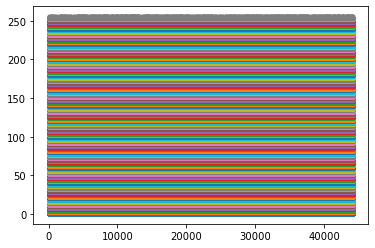

In [10]:
# slow it down by a factor of 10 with a jitter of +/-4, with zero-padding
stimseq = upsample_with_jitter(stimseq,soa=30, jitter=4, latch=False)
stimseq.plot()

In [12]:
# save this modified stim-seq so we can use it in the Screen
stimseq.toFile('level3_gold_soa30.txt')

Saving to: level3_gold_soa30.txt


Now let's use this new stimulus sequence and see if it worked to slow down the stimulus rate.

In [3]:
# create the noisetag object and load a stimulus sequence to play
from mindaffectBCI.noisetag import Noisetag
nt = Noisetag(stimSeq='level3_gold_soa30.txt')
nt.startFlicker()

from mindaffectBCI.presentation.ScreenRunner import initPyglet, run_screen, run
# make the window and run it
window = initPyglet(width=640, height=480)
screen = MinimalStimulusScreen(window,noisetag=nt)
run_screen(window, screen)

flicker: 240 frames, tgt -1
app exit


## Connecting to the Hub

The previous example shows how the stimuli look,  however inorder to make it a valid experiement you need to connect the noisetag to the Hub.   You can do this with `noisetag.connect()` which will try to auto-connect to the first hub found on your network.  

Also, most stimuli have more than 1 trial with some gaps to allow the participant a small break.  As this is such a common type of 'meta-stimulus-sequence' to use, the noisetag already supports this and can easily cause it to happen using the `startPrediction` method, and with the appropriate numbers of trials and durations.   Combining these we have a working experiment with:


In [2]:
# create the noisetag object and load a stimulus sequence to play
from mindaffectBCI.noisetag import Noisetag
# use a 3-level gold code
nt = Noisetag(stimSeq='level3_gold.txt')
# connect to a running hub to record stimulus info
nt.connect()
nt.startPrediction(nTrials=5, trialduration=4)

Trying to auto-discover the utopia-hub server
making discovery object
Using inteface: 192.168.200.39
Got location: 192.168.200.39
.
.
.
.
.
.
Discovery returned 1 utopia-hub servers
Discovered utopia-hub on 192.168.200.39 ...
Tring to connect to: 192.168.200.39:-1
Trying to connect to: 192.168.200.39:8400
Connected!
NewSubscriptions: PFSNMEQ


In [3]:
from mindaffectBCI.presentation.ScreenRunner import initPyglet, run_screen, run
# make the window and run it
window = initPyglet(width=640, height=480)
screen = MinimalStimulusScreen(window,noisetag=nt)
run_screen(window, screen)

C:\Users\Developer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Start Pred: 0/5
tgtidx=-1
2.stim, tgt:-1   240frames
flicker: 240 frames, tgt -1
 with selection

3.feedback 60.0
4033ms pred:-1 sel:0  x
3.wait 60.0
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60


Start Pred: 1/5
tgtidx=-1
2.stim, tgt:-1   240frames
flicker: 240 frames, tgt -1
 with selection

3.feedback 60.0
4018ms pred:-1 sel:0  x
3.wait 60.0
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60


Start Pred: 2/5
tgtidx=-1
2.stim, tgt:-1   240frames
flicker: 240 frames, tgt -1
 with selection

3.feedback 60.0
4019ms pred:-1 sel:0  x
3.wait 60.0
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60


Start Pred: 3/5
tgtidx=-1
2.stim, tgt:-1   240frames
flicker: 240 frames, tgt -1
 with selection

3.feedback 60.0
4015ms pred:-1 sel:0  x
3.wait 60.0
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60


Start Pred: 4/5
tgtidx=-1
2.stim, tgt:-1   240frames
flicker: 240 frames, tgt -1
 with selection

3.feedback 60.0
4019ms pred:-1 sel:0  x
3.wait 60.0
flicke

# Available Stimulus screens

Above we presented the basic functionality needed to make a simple screen, and then a simple stimulus screen.  Obviously, we already have many common screens defined.  A brief overview of available screens in the `presentation.screens` package is:

### User Interface Screens
* `WaitScreen`: Shows text until a time-out or key/mouse is pressed
* `InstructionScreen`: Shows some text on the screen
* `MenuScreen`: Shows a number list of options on the screen, and waits until a valid key is pressed
* `ElectrodeQualityScreen`: Shows summar information about the current live EEG and the quality of each electrode
* `FrameRateTestScreen`: Checks the frame rate of the current display window

### Meta-screens, i.e. screens which contain sub-screens
* `ScreenGraph`: Screen which switches between sub-screens on the basis of a screen transition graph.
* `LoopedScreenGraph`: Screen which loops round a sub-screen graph a number of times
* `SubscreeMenuScreen`: Screen which automatically makes a menu to allow users to manually select which sub-screen to run next.
* `ExptManagerScreen`: Screen which implmenents a complete experiment framework.  This (to date) has been used as the basis of most of our experiment.

### Stimulus Presentation Screens
* `SelectionGridScreen`: Base class for presentation of stimuli, particularly focused on presenting multiple 'flickering' objects on the screen at one time.   Many of the below specific stimuli screens are built from this class
* `SelectionWheelScreen` : Variation of the selection grid where instead of stimuli being shown in a rectangular grid, they are shown as a radius+angle 'dartboard'
* `ImageFlashScreen` : Varition of the selelction grid, where instead of the state defining the color of the grid background, it says which background image to show
* `SoundFlashScreen` : Variation of the selection grid, where the state defines which sound should be playeed every frame.

As it is easier to understand what the different screens do by seeing them run than by description, you can run a _gallery_ screen from the `gallery.json` configuration file by:


In [2]:
from mindaffectBCI.presentation.ScreenRunner import run
run(config_file='gallery.json')

Loading config from: c:\users\developer\desktop\private\mindaffectBCI\config\gallery.json


C:\Users\Developer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Electrode Quality (3600000ms)
use_audio_timestamps=False


C:\Users\Developer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pyglet\media\codecs\wmf.py:838: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Loading: c:\users\developer\desktop\private\mindaffectBCI\presentation\screens\..\audio\digits/MAE_1A.wav
Loading: c:\users\developer\desktop\private\mindaffectBCI\presentation\screens\..\audio\digits/MAE_2A.wav
Loading: c:\users\developer\desktop\private\mindaffectBCI\presentation\screens\..\audio\digits/MAE_3A.wav
Loading: c:\users\developer\desktop\private\mindaffectBCI\presentation\screens\..\audio\digits/MAE_4A.wav
mouse press in line 0  = 9) ImageFlashScreen  (image)
stage transition
flicker: 240 frames, tgt -1

stage transition


## Hands-on assignment: Visual Evoked Potentials

Now you know the basics of how to make a screen, as a user interface and to display stimuli, it's time to get your hands dirty by making a simple experiment.   

For this assignment I would like to to make a simple experiment to investigate visual evoked potentials.   It should have the following.
1. Have a *main menu*, which allows the user to select: electrode quality or stimulus experiment.
2. Have a stimulus sub-screen.

### Stimulus Requirements
To generate strong 'isolated' VEPs the stimuli should have the following properties: 
1. Have a single square in the middle of the screen
2. Have a fixation cross
3. Have the square 'flicker' by going from 'grey' (rgb=(5,5,5)) to 'white' (rgb=(255,255,255))
4. The flicker sequence should the pseudo-random, but *slow*, with stimuli randomly *white* for about 100ms roughly 2 times a second.
5. A single stimulus run should be about 5min, consisting of 40 trials of 10 seconds each, with about a 5s gap between trials.


### Implementation Advice
This should be a very simple assignment, taking you 1-2hr to complete.   To help you with that here are some thoughts to guide your thinking
* "Use an existing screen or make your own"?  Think about what existing screens are available, can they be re-used for (some of the) functionality you need for this application?  If so which bits?  If you need to make your own Screen, what functionality to you need and can you build on an existing screen?   (Hint: `SubscreensMenuScreen`, `SelectionGridScreen`)
* "Use an existing stimulus sequence of make a new one"?  Think about the stimulus sequence properties you need, can you get these properties by re-using an existing stimulus sequence, or should you make a new one?  If you make a new one, can it be made by simply adapting an existing sequence? (Hint: `mindaffectBCI.stimseq.upsample_with_jitter`)
* The `Noisetag` object has a lot of builtin functionality for making a trial based experiemnt.  In particular look at the `startCalibrationPhase` and `startPredictionPhase` methods which will run potentially cued multiple trials with gaps.





### Soln 1: Re-use existing screens & stim-sequences
Specifically:
1. `ConnectingScreen` for the initial connection to the hub
2. `SubscreensMenuScreen` for the main menue
3. `ElectrodeQualityScreen` for the electrode quality
4. `SelectionGridScreen` for the stimulus.  With a single cell symbols set. `symbols=[[' ']]`
5. `upsample_with_jitter` the existing `level2_gold.txt` to make a correct stimulus sequence.
6. use `startPredictionPhase` of the noisetag object to make it run a whole sequence of trials with the given durations.

#### 1. Make the stimulus sequence
Upsample a normal binary pseudo-random sequence by 5 with jitter of 1 without latch to pad with 0's to mean that on-average 2 stimuli are on every 1/6s=10-frames


Saving to: level2_gold_soa5.txt


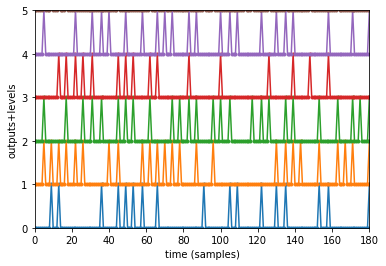

In [6]:
from mindaffectBCI.stimseq import StimSeq, upsample_with_jitter
# load the starting sequence
stimseq = StimSeq.fromFile('level2_gold.txt')
# upsample by 5x with 0-padding to get to 2 stim / 10-frames
stimseq = upsample_with_jitter(stimseq, soa=5, jitter=1, min_soa=2, max_soa=8, latch=False )
# plot&save
stimseq.plot(xlim=(0,180),ylim=(0,5))
stimseq.toFile('level2_gold_soa5.txt') 

### 2. Make the screen

1. Make a sub-screens menu screen to controll the application
2. Make the stimulus-screen
3. Setup the noisetag playback sequence to:
   1. Play the stimulus with a framesperbit=6 to slow down so each 'flash' lasts 100ms
   2. Play the stimuli as a set of 40 trials with a duration of 15s and a 5s gap between, by passing these are arguments to the noisetag in the stimulus screen.

In [7]:
from mindaffectBCI.presentation.screens.SubscreenMenuScreen import SubscreenMenuScreen
from mindaffectBCI.presentation.screens.SelectionGridScreen import SelectionGridScreen
from mindaffectBCI.presentation.screens.ElectrodeQualityScreen import ElectrodeQualityScreen
from mindaffectBCI.presentation.screens.ConnectingScreen import ConnectingScreen

subscreens = {
    'conn':['ConnectingScreen',{}],
    'qual':['ElectrodeQualityScreen',{}],
    'stim':['SelectionGridScreen',{'symbols':[['+']],
                # use the correct color mapping
                "state2color": {"0":[5,5,5],"1":[255,255,255]},
                # setup to run thie stimulus sequence in prediction mode, i.e. no 'target' or cueing
                'noisetag_mode':'prediction',
                # setup the playback arguments -- slowdown, num-trials, trial-duration etc.
                'noisetag_args':{'stimSeq':'level2_gold_soa5.txt',
                                 'framesperbit':6,
                                 'nTrials':40,
                                 'duration':15,
                                 'waitduration':4}}]
}
# start with connecting screen & transition to menu when connection is done
start_screen = 'conn'
subscreen_transitions = { 'conn':'menu' }


In [8]:
# create the noisetag object and load a stimulus sequence to play
from mindaffectBCI.noisetag import Noisetag
# the one we just made
nt = Noisetag()

In [9]:
from mindaffectBCI.presentation.ScreenRunner import initPyglet, run_screen, run
# make the window and run it
window = initPyglet(width=640, height=480)

# connect the screen to the window and noise-tag
screen = SubscreenMenuScreen(window=window, noisetag=nt, 
                             subscreens=subscreens,
                             subscreen_transitions=subscreen_transitions, start_screen=start_screen)


Electrode Quality (3600000ms)


In [10]:

# set the noisetag to run a multi-trial stimulus seqeuence
#nt.startPrediction(nTrials=40, stimSeq='level2_gold_soa30.txt', duration=15, waitduration=5, sendEvents=True)

# run the screen
run_screen(window, screen)

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

## Running from a .json file
For many of the common cases, like above, you don't need to write a completely new `Screen` file, but can work directly with the existing classes with a new stimulus sequence.   In these cases you can instead directly make a BCI application configuration to run your experiment.  For this experiment this .json config looks very much like the above code and can be given as:

In [1]:
config={
    # set to run from the ScreenRunner
    "presentation": "mindaffectBCI.presentation.ScreenRunner",
    # setup the screen to run..
    "presentation_args": {
        "width": 1024,
        "height": 768,
        # set the noisetag object to use, and the stimsequence to play
        "noisetag": {
            "stimSeq": "level2_gold_soa5.txt"
        },
        # set main screen to show.  Here we use the sub-screen menu screen to build a menu of sub-screens to show
        "screen": [
            "mindaffectBCI.presentation.screens.SubscreenMenuScreen.SubscreenMenuScreen",
            {
                "title": "Minimal Application Example",
                # here is the list of sub-screens to select from in the main menu
                # the format is : "name":[ScreenClassName, screen_args]
                # where screenclass name is either a fullyqualified class name, or a class in 'mindaffectBCI.presentation.screens' with the same filename and class name
                # and screen_args is a dictionary of arguments to pass to the screen constructor
                "subscreens": {
                    "conn": ["ConnectingScreen", {} ],
                    "elect": [ "ElectrodeQualityScreen", { "label": "Electrode Quality Screen" } ],
                    "stim": ["SelectionGridScreen", {
                            # single block in the middle of the screen with a + as fixation
                            "symbols": [ [ "+" ] ],
                            # use the correct color mapping
                            "state2color": { "0":[5,5,5], "1":[255,255,255] },
                            # setup to run thie stimulus sequence in prediction mode, i.e. no 'target' or cueing
                            "noisetag_mode": "prediction",
                            # setup the playback arguments -- slowdown, num-trials, trial-duration etc.
                            "noisetag_args": {
                                "stimSeq": "level2_gold_soa5.txt", # 5x slowdown = 2 events / 10 frames
                                "framesperbit": 6, # 6x slowdown = 100ms stimulus rate = 10 frames / sec
                                "nTrials": 40,
                                "duration": 15, # 15s trial duration
                                "waitduration": 4
                            }
                        }
                    ]
                },
                # start with connecting screen & transition to menu when connection is done
                "start_screen": "conn",
                "subscreen_transitions": { "conn": "menu" }
            }
        ]
    }
}

You can either put this directly into an application .json, with an acquisition and decoder config.  In this case you can see this in the file [`config\TutorialScreen.json`](../../config/TutorialScreen.json).

Also as a convience you can test if a .json config stored in a python dictionary directly with:

In [2]:
from mindaffectBCI.presentation.ScreenRunner import run
run(config_file=config)

C:\Users\Developer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Electrode Quality (3600000ms)
Not connected yet!!
Trying to auto-discover the utopia-hub server
making discovery object
Using inteface: 192.168.200.39
.
Discovery returned 0 utopia-hub servers
Error:: couldnt autodiscover the decoder!
Tring to connect to: localhost:-1
Trying to connect to: localhost:8400
Connection refused...  Waiting
[WinError 10061] No connection could be made because the target machine actively refused it
Socket error connecting: 
Connection Refused!
Not connected yet!!
Trying to auto-discover the utopia-hub server
.
Discovery returned 0 utopia-hub servers
Error:: couldnt autodiscover the decoder!
Tring to connect to: localhost:-1
Trying to connect to: localhost:8400
Connection refused...  Waiting
[WinError 10061] No connection could be made because the target machine actively refused it
Socket error connecting: 
Connection Refused!
stage transition
mouse press in line 0  = 2) SelectionGridScreen  (stim)
stage transition
noisetag_reset
noisetag::prediction {'stimSeq